In [ ]:
%%bash 

python -m spacy download en
python -m spacy download de

In [ ]:
!pip install torchtext

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import Multi30k
from typing import Iterable, List

import spacy
import numpy as np

import random
import math
import time

In [4]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

In [6]:
# place-holder directories
token_transform = {}
vocab_transform = {}

In [7]:
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en')

In [8]:
# helper function to yield list of tokens
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

In [9]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure that tokens are in the or4der of their indices to properly insert them in Vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

In [10]:
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  # training data iterator
  train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
  # create torchtext's vocab object
  vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                  min_freq=1,
                                                  specials = special_symbols,
                                                  special_first=True
                                                  )

100%|██████████| 1.21M/1.21M [00:02<00:00, 571kB/s] 


In [11]:
# We need to set UNK_IDX as the defaul index. This index is requtrned when the token
# is not found. If this is NOT set, it throws RUNTIMEERROR when the queried token
# is not found in the vocabulary

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [13]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

In [14]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

In [15]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

In [16]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

In [17]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

In [18]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

In [19]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

In [20]:
BATCH_SIZE = 64
INPUT_DIM = len(vocab_transform[SRC_LANGUAGE])
OUTPUT_DIM = len(vocab_transform[TGT_LANGUAGE])
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [21]:
SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,482,520 trainable parameters


In [23]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)


model.apply(initialize_weights);

In [24]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [25]:
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [26]:
######################################################################
# Collation
# ---------
#   
# As seen in the ``Data Sourcing and Processing`` section, our data iterator yields a pair of raw strings. 
# We need to convert these string pairs into the batched tensors that can be processed by our ``Seq2Seq`` network 
# defined previously. Below we define our collate function that convert batch of raw strings into batch tensors that
# can be fed directly into our model.   
#


from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and tgt language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX, batch_first=True)
    return src_batch, tgt_batch

In [27]:
######################################################################
# Let's define training and evaluation loop that will be called for each 
# epoch.
#

from torch.utils.data import DataLoader

def train_epoch(model, optimizer):
    model.train()
    losses = 0
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)
    
    for src, tgt in train_dataloader:
        src = src.to(device)
        tgt = tgt.to(device)
        # print(src.shape)
        # print(tgt.shape)
        # print(tgt[:,:-1].shape)

        optimizer.zero_grad()
        output, _ = model(src, tgt[:,:-1]) #[:,:-1])

        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        tgt = tgt[:,1:].contiguous().view(-1)

        # output = output[1:].view(-1, output.shape[-1])
        # tgt = tgt[1:].reshape(-1) #tgt[:,:-1][1:].reshape(-1)
        loss = loss_fn(output, tgt)
        loss.backward()
        clip = 1
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()
        losses += loss.item()

    return losses / len(train_dataloader)


def evaluate(model):
    model.eval()
    losses = 0

    val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(device)
        tgt = tgt.to(device)[:,:-1]

        output, _ = model(src, tgt[:,:-1])
            
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
        
        output_dim = output.shape[-1]
        
        output = output.contiguous().view(-1, output_dim)
        tgt = tgt[:,1:].contiguous().view(-1)

        # output = output[1:].view(-1, output.shape[-1])
        # tgt = tgt[1:].reshape(-1)
        loss = loss_fn(output, tgt)
        losses += loss.item()

    return losses / len(val_dataloader)


In [28]:
from timeit import default_timer as timer
NUM_EPOCHS = 10
train_losses = []
val_losses = []

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(model, optimizer)
    end_time = timer()
    val_loss = evaluate(model)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Train PPL: {math.exp(train_loss):7.3f} | Val loss: {val_loss:.3f}, Val. PPL: {math.exp(val_loss):7.3f} | "f"Epoch time = {(end_time - start_time):.3f}s"))
    train_losses.append(train_loss)
    val_losses.append(val_loss)


100%|██████████| 46.3k/46.3k [00:00<00:00, 174kB/s]


Epoch: 1, Train loss: 4.019, Train PPL:  55.633 | Val loss: 3.023, Val. PPL:  20.552 | Epoch time = 23.977s
Epoch: 2, Train loss: 2.632, Train PPL:  13.895 | Val loss: 2.388, Val. PPL:  10.896 | Epoch time = 23.991s
Epoch: 3, Train loss: 2.059, Train PPL:   7.839 | Val loss: 2.147, Val. PPL:   8.562 | Epoch time = 24.272s
Epoch: 4, Train loss: 1.693, Train PPL:   5.434 | Val loss: 2.051, Val. PPL:   7.776 | Epoch time = 24.658s
Epoch: 5, Train loss: 1.421, Train PPL:   4.142 | Val loss: 2.029, Val. PPL:   7.608 | Epoch time = 24.655s
Epoch: 6, Train loss: 1.213, Train PPL:   3.364 | Val loss: 2.070, Val. PPL:   7.923 | Epoch time = 24.448s
Epoch: 7, Train loss: 1.040, Train PPL:   2.830 | Val loss: 2.058, Val. PPL:   7.827 | Epoch time = 24.538s
Epoch: 8, Train loss: 0.902, Train PPL:   2.465 | Val loss: 2.110, Val. PPL:   8.247 | Epoch time = 24.652s
Epoch: 9, Train loss: 0.787, Train PPL:   2.196 | Val loss: 2.165, Val. PPL:   8.715 | Epoch time = 24.417s
Epoch: 10, Train loss: 0.694

In [29]:
test_loss = evaluate(model)

In [30]:
def translate_sentence(sentence, src_field, trg_field, model, device, init_token, eos_token, max_len = 50):
    
    model.eval()
        
    if isinstance(sentence, str):
        src_tensor = text_transform[SRC_LANGUAGE](sentence).unsqueeze(0).to(device)
    else:
        src_tensor = text_transform[TGT_LANGUAGE](sentence).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field[init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field[eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.get_itos()[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [31]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [32]:
data_iter = Multi30k(split='test', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
c = 0

print("*"*40)
print("German to English Translations:-")
print("*"*40)
for src, trg in list(data_iter):
  print('\n')
  print(f"{c+1}) Germal Sentence: {src}")
  print(f"Target English Sentence: {trg}")
  
  pred, attention = translate_sentence(src, vocab_transform[SRC_LANGUAGE], vocab_transform[TGT_LANGUAGE], model, device, '<bos>', '<eos>')

  print(f"Predicted English Sentence: {' '.join(pred[:-1])}")
  # print("Attention Map: ")
  # display_attention(src, pred, attention)

  c += 1
  if c >= 10:
    break

100%|██████████| 43.9k/43.9k [00:00<00:00, 165kB/s]


****************************************
German to English Translations:-
****************************************


1) Germal Sentence: Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.

Target English Sentence: A man in an orange hat starring at something.

Predicted English Sentence: A man in an orange hat is spraying a golf ball .


2) Germal Sentence: Ein Boston Terrier läuft über saftig-grünes Gras vor einem weißen Zaun.

Target English Sentence: A Boston Terrier is running on lush green grass in front of a white fence.

Predicted English Sentence: A Boston terrier runs in grass in front of a white fence .


3) Germal Sentence: Ein Mädchen in einem Karateanzug bricht einen Stock mit einem Tritt.

Target English Sentence: A girl in karate uniform breaking a stick with a front kick.

Predicted English Sentence: A girl in a karate uniform is shooting a stick with a stick .


4) Germal Sentence: Fünf Leute in Winterjacken und mit Helmen stehen im Schnee mit Schneemobilen im 

****************************************
German to English Translations:-
****************************************


1) German Sentence: Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.

Target English Sentence: A man in an orange hat starring at something.

Predicted English Sentence: A man in an orange hat is spraying a golf ball .
Attention Map: 


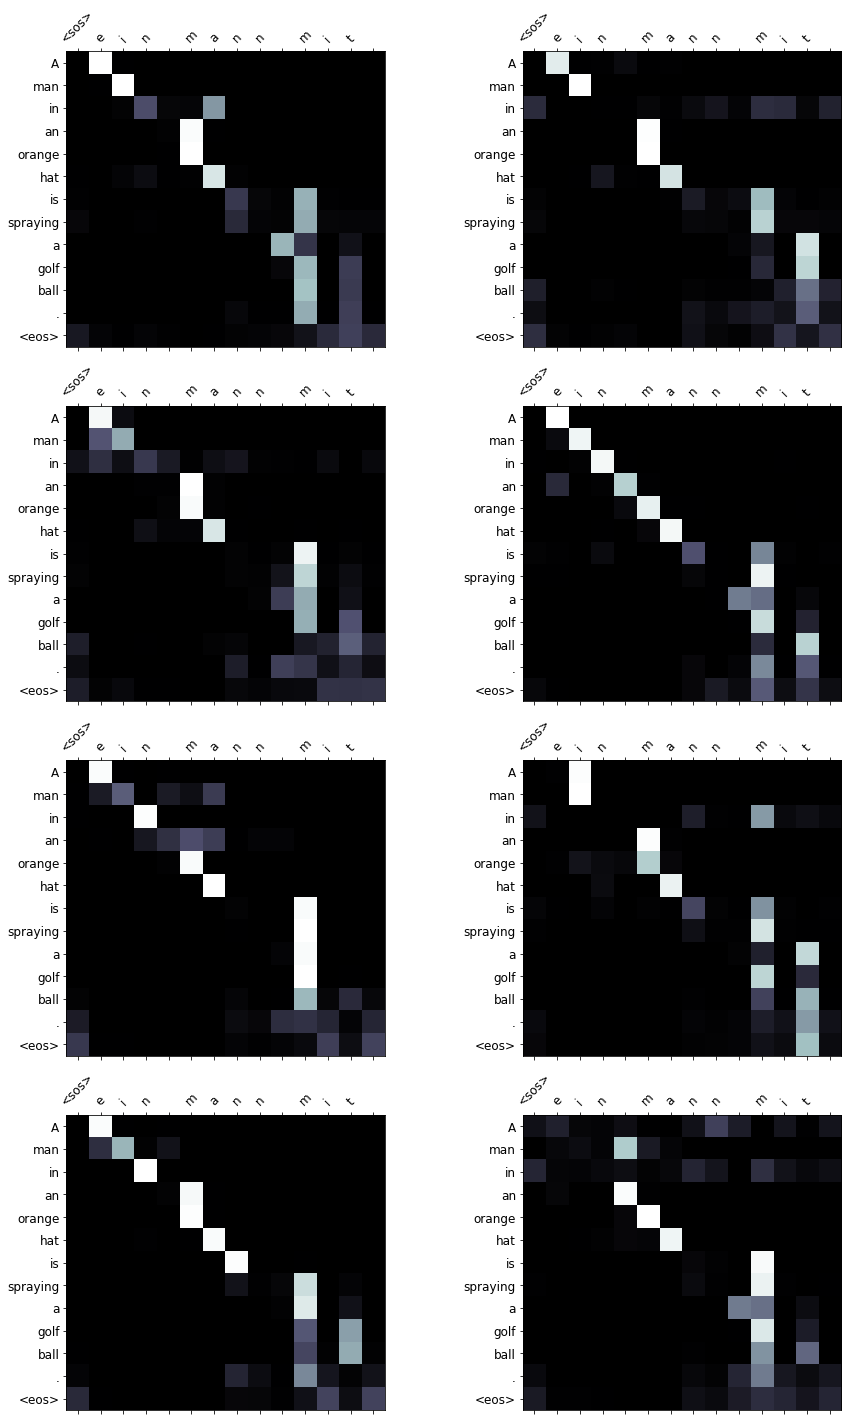



2) German Sentence: Ein Boston Terrier läuft über saftig-grünes Gras vor einem weißen Zaun.

Target English Sentence: A Boston Terrier is running on lush green grass in front of a white fence.

Predicted English Sentence: A Boston terrier runs in grass in front of a white fence .
Attention Map: 


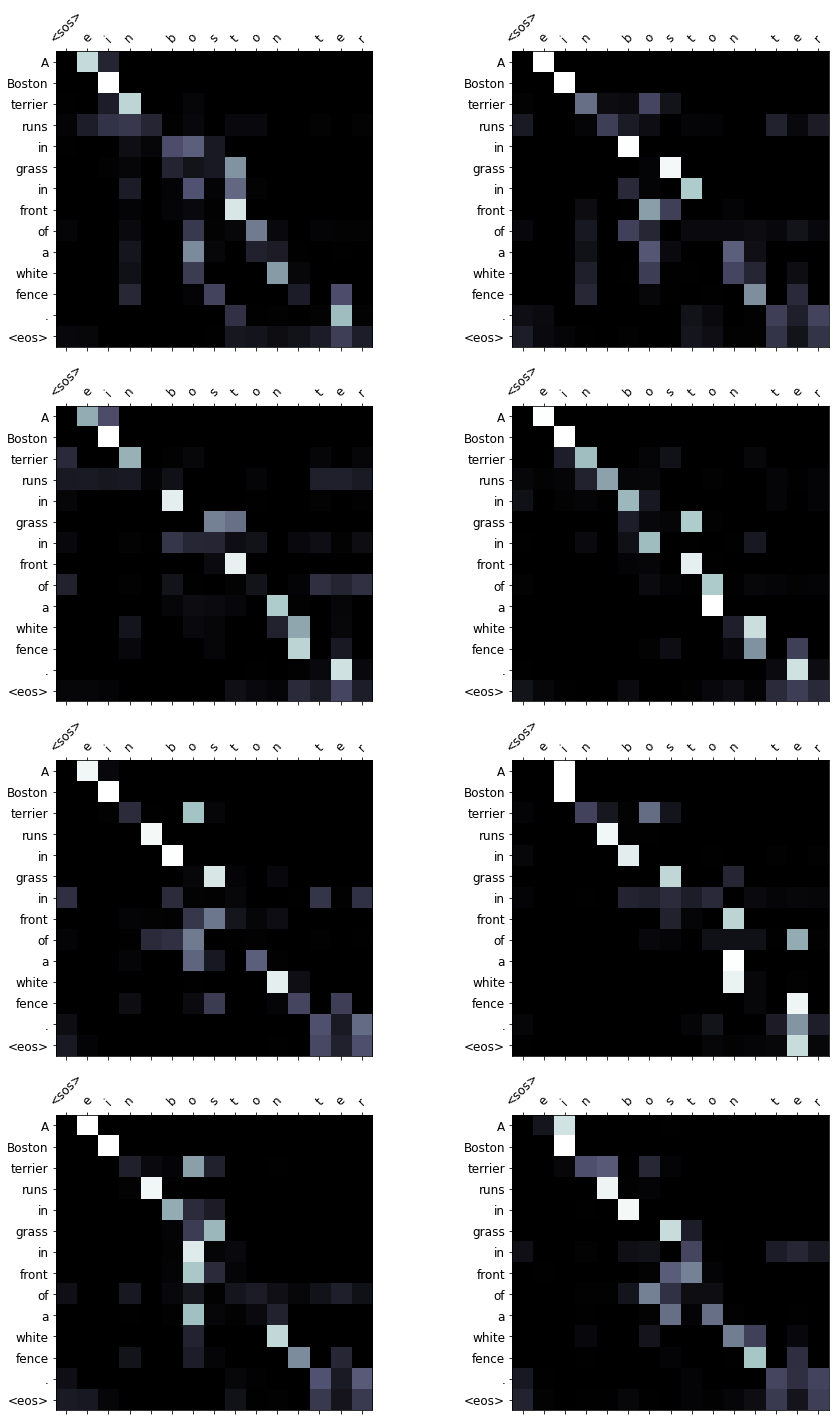



3) German Sentence: Ein Mädchen in einem Karateanzug bricht einen Stock mit einem Tritt.

Target English Sentence: A girl in karate uniform breaking a stick with a front kick.

Predicted English Sentence: A girl in a karate uniform is shooting a stick with a stick .
Attention Map: 


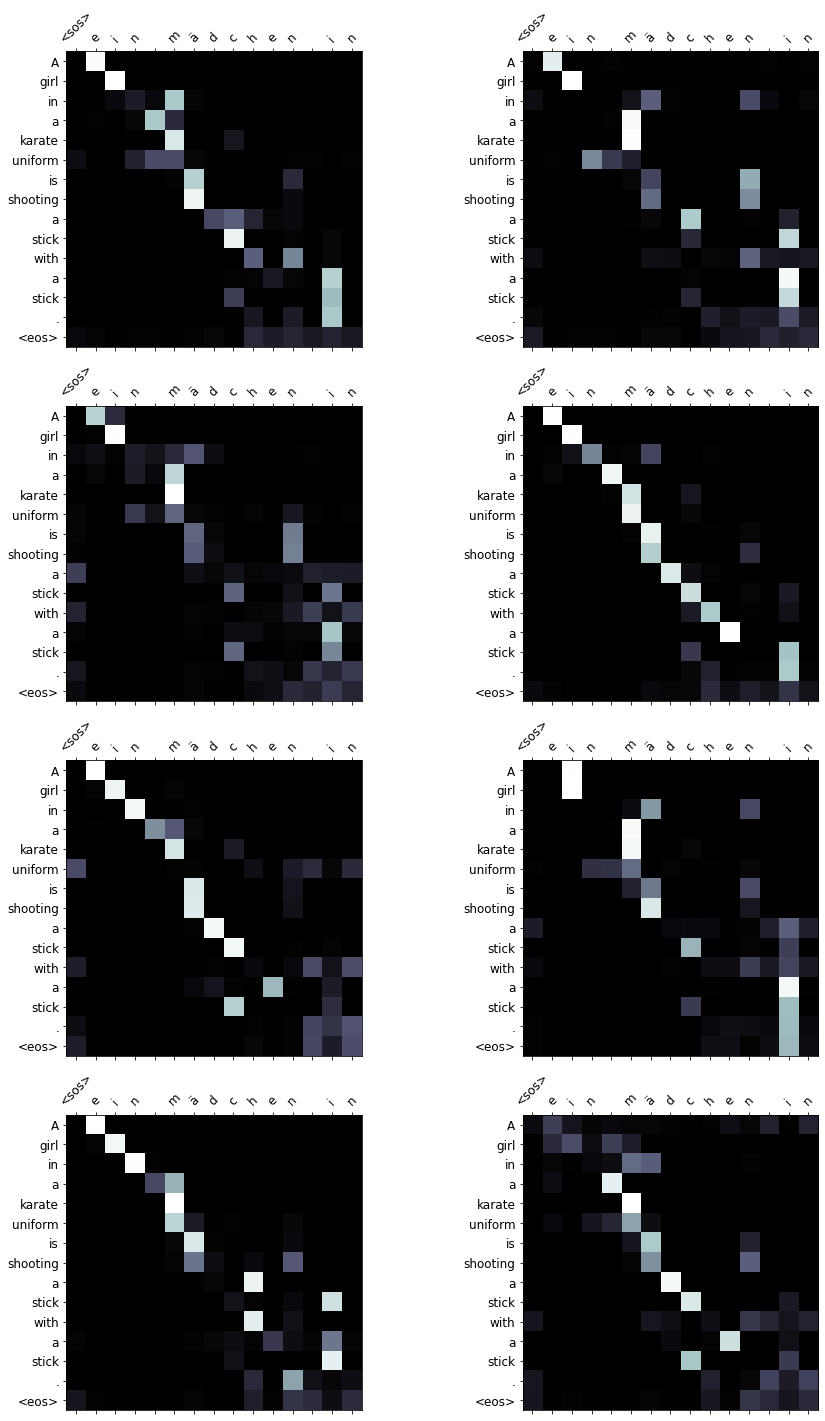



4) German Sentence: Fünf Leute in Winterjacken und mit Helmen stehen im Schnee mit Schneemobilen im Hintergrund.

Target English Sentence: Five people wearing winter jackets and helmets stand in the snow, with snowmobiles in the background.

Predicted English Sentence: Five people in winter gear stand in the snow with helmets in the background .
Attention Map: 


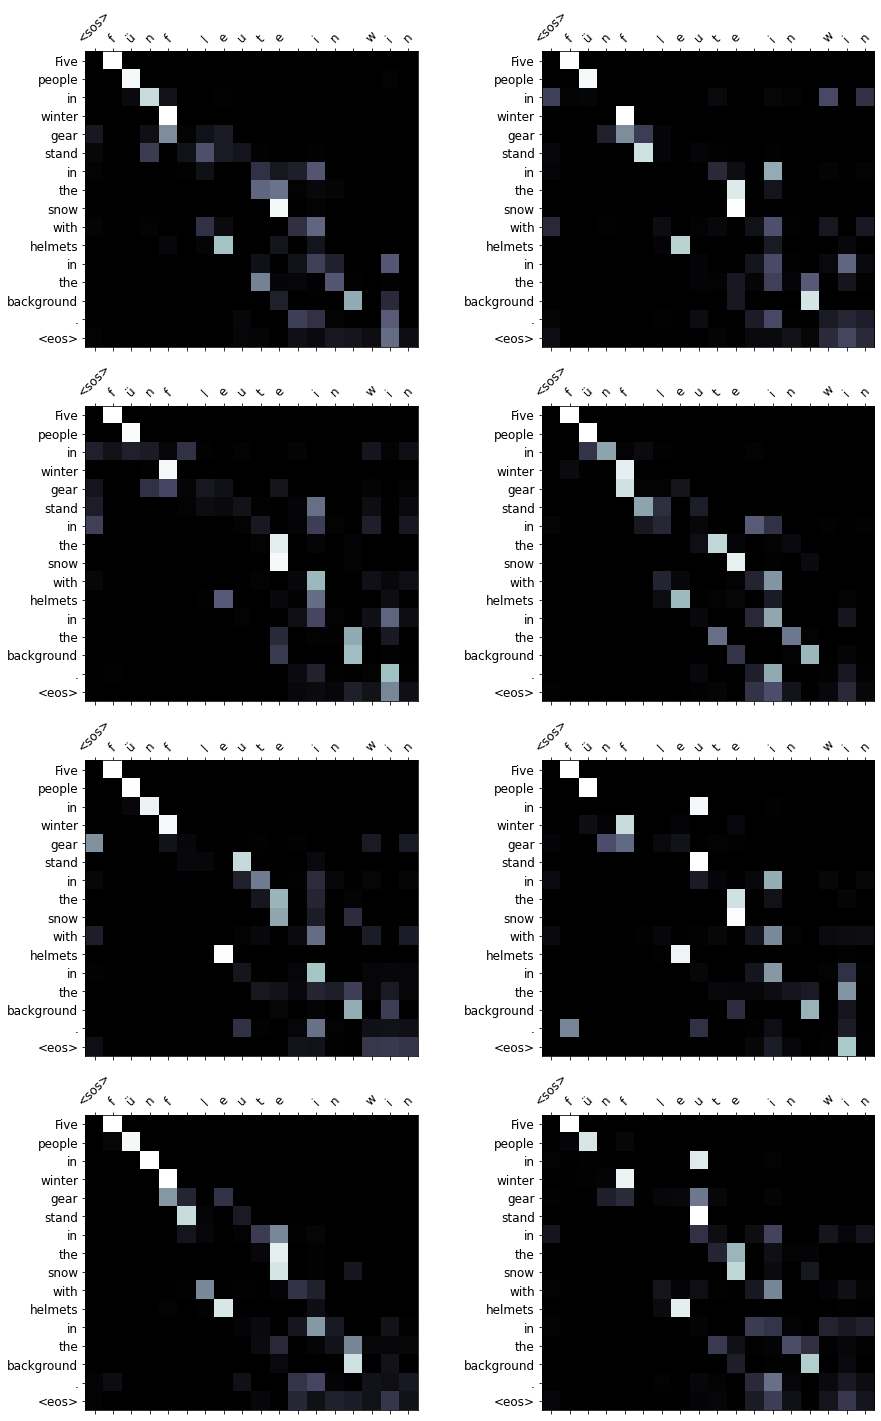



5) German Sentence: Leute Reparieren das Dach eines Hauses.

Target English Sentence: People are fixing the roof of a house.

Predicted English Sentence: People are horseback 's landing from a house .
Attention Map: 


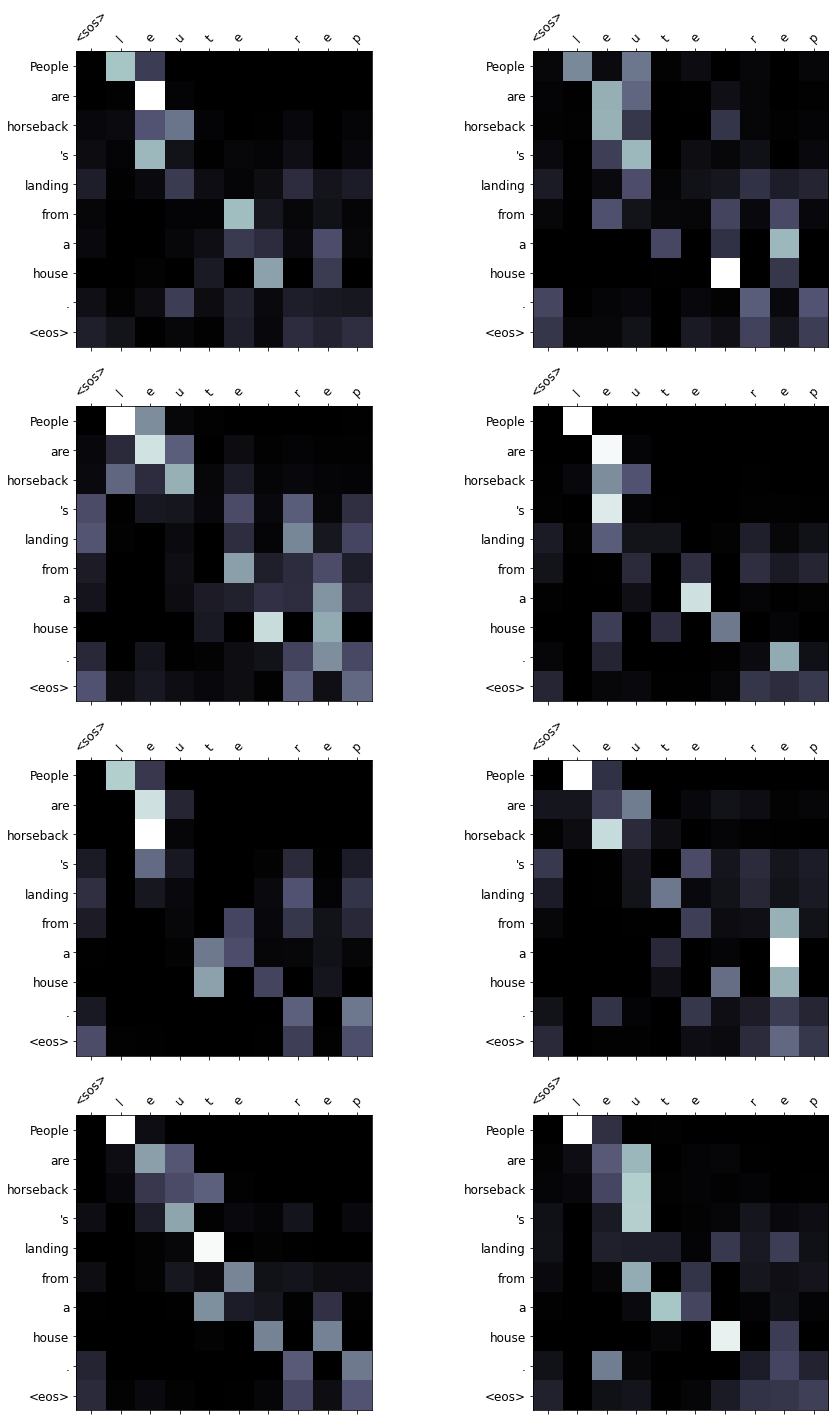

In [33]:
data_iter = Multi30k(split='test', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
c = 0

print("*"*40)
print("German to English Translations:-")
print("*"*40)
for src, trg in list(data_iter):
  print('\n')
  print(f"{c+1}) German Sentence: {src}")
  print(f"Target English Sentence: {trg}")
  
  pred, attention = translate_sentence(src, vocab_transform[SRC_LANGUAGE], vocab_transform[TGT_LANGUAGE], model, device, '<bos>', '<eos>')

  print(f"Predicted English Sentence: {' '.join(pred[:-1])}")
  print("Attention Map: ")
  display_attention(src, pred, attention)

  c += 1
  if c >= 5:
    break

In [34]:
!nvidia-smi

Thu Jan 13 06:56:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    33W /  70W |   4018MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [34]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)
print(f'BLEU score = {bleu_score*100:.2f}')